## Accessing Sentinel-3 OLCI data with the Planetary Computer STAC API

The [Sentinel 3 OLCI instrument](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-olci) provides radiance measurements of the Earth's surface in the visible and near infra-red spectral domain.
These measurements are processed into two Level 2 products, one for the ocean and one for the land.
Each product has its own STAC collection in the Planetary Computer:

- Land: `sentinel-3-olci-lfr-l2-netcdf`
- Ocean: `sentinel-3-olci-wfr-l2-netcdf`

This notebook demonstrates accessing and visualizing data from both collections.

### Data Access

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. If you are using the [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) to run this notebook, then your API key is automatically set to the environment variable `PC_SDK_SUBSCRIPTION_KEY` for you when your server is started. Otherwise, you can view your keys by signing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be manually set via the environment variable `PC_SDK_SUBSCRIPTION_KEY` or the following code:

```python
import planetary_computer
planetary_computer.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available in [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.



### Water products

The collection description tells us more about the water products.

In [1]:
import planetary_computer
import pystac_client
from IPython.display import display, Markdown

catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("sentinel-3-olci-wfr-l2-netcdf")
display(Markdown(f"### {collection.id}\n\n{collection.description}"))

### sentinel-3-olci-wfr-l2-netcdf

This Collection provides Sentinel-3 Full Resolution [OLCI Level-2 Water][olci-l2] products containing data on water-leaving reflectance, ocean color, and more.

## Data files

This dataset includes data on:

- Surface directional reflectance
- Chlorophyll-a concentration
- Suspended matter concentration
- Energy flux
- Aerosol load
- Integrated water vapor column

Each variable is contained within NetCDF files. Error estimates are available for each product.

## Processing overview

The values in the data files have been converted from Top of Atmosphere radiance to reflectance, and include various corrections for gaseous absorption and pixel classification. More information about the product and data processing can be found in the [User Guide](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-olci/product-types/level-2-water) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-olci/level-2/processing).

This Collection contains Level-2 data in NetCDF files from November 2017 to present.

[olci-l2]: https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-olci/level-2/ocean-products


### Define the area of interest and search the water collection

We'll search for items over the coordinates `[-2.79, 44.14]`.

In [2]:
import xarray as xr
import fsspec

search = catalog.search(
    collections=["sentinel-3-olci-wfr-l2-netcdf"],
    intersects={"type": "Point", "coordinates": [-2.79, 44.14]},
)
item = next(search.items())

### Available Assets and Metadata

Each item includes a handful of assets linking to NetCDF files with the data or additional metadata files.

In [3]:
import rich.table

t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                 ┃ Value                                                                                     ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ iwv                 │ Integrated water vapour column                                                            │
│ par                 │ Photosynthetically active radiation                                                       │
│ trsp                │ Transparency properties of water                                                          │
│ wqsf                │ Water quality and science flags                                                           │
│ w-aer               │ Aerosol over water                                                                        │
│ chl-nn              │ Neural net chlorophyll concentration                                                      │
│ iop-nn              │ Inherent optical properties of water                                                      │
│ tsm-nn              │ Total suspended matter concentration                                                      │
│ chl-oc4me           │ OC4Me algorithm chlorophyll concentration                                                 │
│ tie-meteo           │ Tie-point meteo annotations                                                               │
│ browse-jpg          │ Preview image produced by the European Organisation for the Exploitation of               │
│                     │ Meteorological Satellites (EUMETSAT)                                                      │
│ eop-metadata        │ Metadata produced by the European Organisation for the Exploitation of Meteorological     │
│                     │ Satellites (EUMETSAT)                                                                     │
│ safe-manifest       │ SAFE product manifest                                                                     │
│ tie-geometries      │ Tie-point geometry annotations                                                            │
│ geo-coordinates     │ Geo coordinate annotations                                                                │
│ instrument-data     │ Instrument annotations                                                                    │
│ oa01-reflectance    │ Reflectance for OLCI acquisition band Oa01                                                │
│ oa02-reflectance    │ Reflectance for OLCI acquisition band Oa02                                                │
│ oa03-reflectance    │ Reflectance for OLCI acquisition band Oa03                                                │
│ oa04-reflectance    │ Reflectance for OLCI acquisition band Oa04                                                │
│ oa05-reflectance    │ Reflectance for OLCI acquisition band Oa05                                                │
│ oa06-reflectance    │ Reflectance for OLCI acquisition band Oa06                                                │
│ oa07-reflectance    │ Reflectance for OLCI acquisition band Oa07                                                │
│ oa08-reflectance    │ Reflectance for OLCI acquisition band Oa08                                                │
│ oa09-reflectance    │ Reflectance for OLCI acquisition band Oa09                                                │
│ oa10-reflectance    │ Reflectance for OLCI acquisition band Oa10                                                │
│ oa11-reflectance    │ Reflectance for OLCI acquisition band Oa11                                                │
│ oa12-reflectance    │ Reflectance for OLCI acquisition band Oa12                                                │
│ oa16-reflectance    │ Reflectance for OLCI acquisition band Oa16                                                │
│ oa17-reflectance    │ Reflectance for OLCI acquisition

### Reading data

We can use xarray to read each NetCDF file directly from Blob Storage.

In [4]:
keys = [
    "iwv",
    "par",
    "trsp",
    "w-aer",
    "chl-nn",
    "iop-nn",
    "tsm-nn",
    "chl-oc4me",
    "oa01-reflectance",
]
datasets = [xr.open_dataset(fsspec.open(item.assets[k].href).open()) for k in keys]

ds = xr.combine_by_coords(datasets, join="exact", combine_attrs="drop_conflicts")
ds

<xarray.Dataset>
Dimensions:               (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables: (12/20)
    A865                  (rows, columns) float32 ...
    A865_err              (rows, columns) float32 ...
    T865                  (rows, columns) float32 ...
    T865_err              (rows, columns) float32 ...
    ADG443_NN             (rows, columns) float32 ...
    ADG443_NN_err         (rows, columns) float32 ...
    ...                    ...
    Oa01_reflectance      (rows, columns) float32 ...
    Oa01_reflectance_err  (rows, columns) float32 ...
    PAR                   (rows, columns) float32 ...
    PAR_err               (rows, columns) float32 ...
    TSM_NN                (rows, columns) float32 ...
    TSM_NN_err            (rows, columns) float32 ...
Attributes: (12/16)
    absolute_orbit_number:  37440
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2023-04-27T22:46:55Z
    ...                     ...
    product_name:           S3A_OL_2_WFR____20230426T101313_20230426T101613_2...
    references:             S3IPF PDS 004.3 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.03
    start_time:             2023-04-26T10:13:12.833498Z
    stop_time:              2023-04-26T10:16:12.798519Z

We'll plot the integrated water vapor variable.

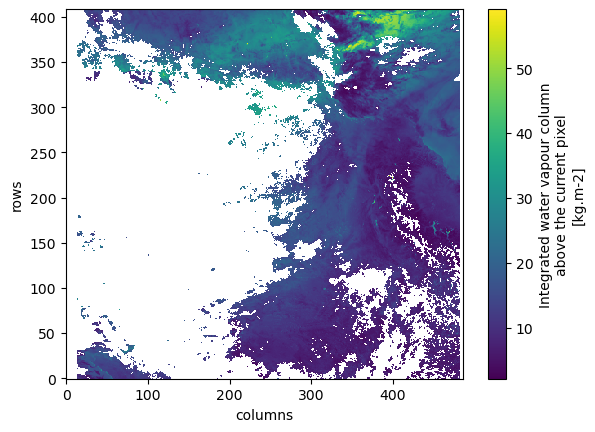

In [5]:
ds.IWV.coarsen({"rows": 10, "columns": 10}, boundary="trim").mean().plot();

### Geolocating the data

The geospatial information in this dataset is distributed as a separate NetCDF file, cataloged under the `geoCoordinates` key. That contains a dataset with `latitude` and `longitude` arrays, each of which is the same shape as the data variables and gives the latitude and longitude for each pixel in data variable.

We'll reshape the data to a (long-form) DataFrame with a single row for each pixel. We'll then make a scatter plot, using the longitude and latitude as the `x` and `y` coordintes.

In [6]:
import pandas as pd
import datashader
import colorcet

geo = xr.open_dataset(fsspec.open(item.assets["geo-coordinates"].href).open()).load()
a01 = ds.Oa01_reflectance.load()


df = pd.DataFrame(
    {
        "longitude": geo.longitude.data.ravel(),
        "latitude": geo.latitude.data.ravel(),
        "value": a01.data.ravel(),
    }
)

To avoid overplotting the data, we'll use [datashader](https://datashader.org/).

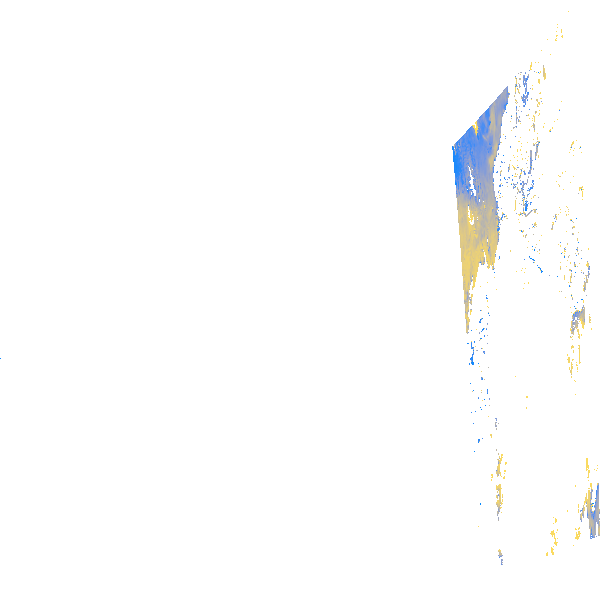

In [7]:
cvs = datashader.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(df, "latitude", "longitude", agg=datashader.reductions.mean("value"))
img = datashader.tf.shade(agg, cmap=colorcet.CET_CBD2)
img

### Land data

Let's do the same process, but for the land product.

In [8]:
collection = catalog.get_collection("sentinel-3-olci-lfr-l2-netcdf")
display(Markdown(f"### {collection.id}\n\n{collection.description}"))

### sentinel-3-olci-lfr-l2-netcdf

This collection provides Sentinel-3 Full Resolution [OLCI Level-2 Land][olci-l2] products containing data on global vegetation, chlorophyll, and water vapor.

## Data files

This dataset includes data on three primary variables:

* OLCI global vegetation index file
* terrestrial Chlorophyll index file
* integrated water vapor over water file.

Each variable is contained within a separate NetCDF file, and is cataloged as an asset in each Item.

Several associated variables are also provided in the annotations data files:

* rectified reflectance for red and NIR channels (RC681 and RC865)
* classification, quality and science flags (LQSF)
* common data such as the ortho-geolocation of land pixels, solar and satellite angles, atmospheric and meteorological data, time stamp or instrument information. These variables are inherited from Level-1B products.

This full resolution product offers a spatial sampling of approximately 300 m.

## Processing overview

The values in the data files have been converted from Top of Atmosphere radiance to reflectance, and include various corrections for gaseous absorption and pixel classification. More information about the product and data processing can be found in the [User Guide](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-olci/product-types/level-2-land) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-olci/level-2/processing).

This Collection contains Level-2 data in NetCDF files from April 2016 to present.

[olci-l2]: https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-olci/level-2/land-products


In [9]:
search = catalog.search(
    collections=["sentinel-3-olci-lfr-l2-netcdf"],
    intersects={"type": "Point", "coordinates": [-2.79, 44.14]},
)
item = next(search.items())
t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                 ┃ Value                                                                                ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ iwv                 │ Integrated water vapour column                                                       │
│ lqsf                │ Land quality and science flags                                                       │
│ otci                │ OLCI Terrestrial Chlorophyll Index (OTCI)                                            │
│ gifapar             │ Green instantaneous Fraction of Absorbed Photosynthetically Active Radiation (FAPAR) │
│ tie-meteo           │ Tie-point meteo annotations                                                          │
│ rc-gifapar          │ Rectified reflectance                                                                │
│ safe-manifest       │ SAFE product manifest                                                                │
│ tie-geometries      │ Tie-point geometry annotations                                                       │
│ geo-coordinates     │ Geo coordinate annotations                                                           │
│ instrument-data     │ Instrument annotations                                                               │
│ time-coordinates    │ Time coordinate annotations                                                          │
│ tie-geo-coordinates │ Tie-point geo coordinate annotations                                                 │
└─────────────────────┴──────────────────────────────────────────────────────────────────────────────────────┘

### Plot FAPAR

The green instantaneous Fraction of Absorbed Photosynthetically Active Radiation (FAPAR) product uses a [vegetation index algorithm](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-olci/level-2/olci-global-vegetation-index) to provide an estimate of the FARAR in the plant canopy.

In [10]:
dataset = xr.open_dataset(fsspec.open(item.assets["gifapar"].href).open())
dataset

<xarray.Dataset>
Dimensions:      (rows: 4091, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    GIFAPAR      (rows, columns) float32 ...
    GIFAPAR_unc  (rows, columns) float32 ...
Attributes: (12/17)
    absolute_orbit_number:  37497
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2023-05-01T13:41:05Z
    ...                     ...
    references:             S3IPF PDS 004.2 - i2r4 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 06.16
    start_time:             2023-04-30T10:09:29.096122Z
    stop_time:              2023-04-30T10:12:29.061141Z
    title:                  OLCI Level 2 LAND Product, GIFAPAR Data Set

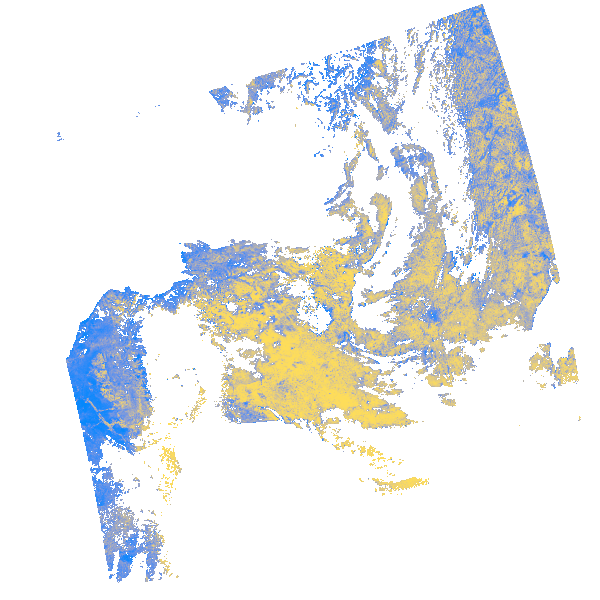

In [11]:
geo = xr.open_dataset(fsspec.open(item.assets["geo-coordinates"].href).open()).load()
fapar = dataset.GIFAPAR.load()

df = pd.DataFrame(
    {
        "longitude": geo.longitude.data.ravel(),
        "latitude": geo.latitude.data.ravel(),
        "value": fapar.data.ravel(),
    }
)
cvs = datashader.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(df, "latitude", "longitude", agg=datashader.reductions.mean("value"))
img = datashader.tf.shade(agg, cmap=colorcet.CET_CBD2)
img